<a href="https://colab.research.google.com/github/Atruk/Hackathon_Innopolis/blob/main/Krypton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



To submit you solution you have to upload submission.csv file with binary labeled molecules  as model outputs

F1 metric will be used for evaluation

For structure-based design we also publish pdb structure of target protein https://drive.google.com/file/d/1mzN79wT50jOw9mT2npY1TUKJlTfCoQoG/view?usp=sharing&roistat_visit=377092


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing 
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

%matplotlib inline

Mounted at /content/drive


In [ ]:
# labels_test_dataset_path = '/content/drive/MyDrive/Hackathon_Innopolis/labels_test_dataset.csv'
test_dataset_path = '/content/drive/MyDrive/Hackathon_Innopolis/test.csv'
train_dataset_path = '/content/drive/MyDrive/Hackathon_Innopolis/train.csv'

# train.csv, test.csv - Preparation and preprocessing of datasets


## train.csv

In [ ]:
df_train = pd.read_csv(train_dataset_path, usecols=['Smiles', 'Active'])
df_train.head()

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,False
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,False
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,False
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,False
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,False


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5557 entries, 0 to 5556
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Smiles  5557 non-null   object
 1   Active  5557 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 49.0+ KB


In [ ]:
df_train.describe(include='all')

,Smiles,Active
count,5557,5557
unique,5557,2
top,COc1ccc2[nH]cc(CCN)c2c1,False
freq,1,5351


In [ ]:
# Convert 'Active' column to int: False - 0, True - 1
df_train["Active"] = df_train["Active"].astype("int64")
df_train

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,0
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,0
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,0
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,0
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,0
...,...,...
5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,0
5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,0
5554,Oc1cccc2cccnc12,0
5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,0


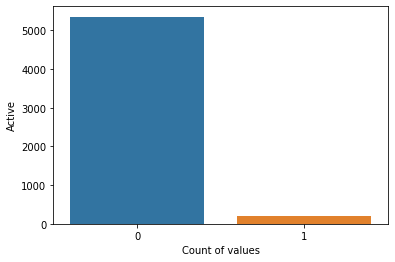

In [ ]:
sns.countplot(data = df_train, x='Active', orient='v')
plt.ylabel('Active')
plt.xlabel('Count of values')
plt.show()

In [ ]:
df_train['Smiles'].nunique()

5557

In [ ]:
df_train['Active'].value_counts()

0    5351
1     206
Name: Active, dtype: int64

In [ ]:
!python -m pip install rdkit-pypi

In [ ]:
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-z12az105
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-z12az105


In [ ]:
# Importing Chem module
from rdkit import Chem 
from rdkit.Chem import Descriptors

# Method transforms smiles strings to mol rdkit object
df_train['mol'] = df_train['Smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 

print(type(df_train['mol'][0]))

<class 'rdkit.Chem.rdchem.Mol'>


In [ ]:
df_train 

,Smiles,Active,mol
0,COc1ccc2[nH]cc(CCN)c2c1,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bfc19e0>
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bfc1990>
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bfc1a80>
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bfc1ad0>
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bfc1b20>
...,...,...,...
5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bf369e0>
5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bf36a30>
5554,Oc1cccc2cccnc12,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bf36a80>
5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,0,<rdkit.Chem.rdchem.Mol object at 0x7f8f9bf36ad0>


In [ ]:
# Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('/content/drive/MyDrive/Hackathon_Innopolis/model_300dim.pkl')

In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [ ]:
#Extract descriptors
df_train['tpsa'] = df_train['mol'].apply(lambda x: Descriptors.TPSA(x))
df_train['mol_w'] = df_train['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df_train['num_valence_electrons'] = df_train['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df_train['num_heteroatoms'] = df_train['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [ ]:
df_train.columns

Index(['Smiles', 'Active', 'mol', 'tpsa', 'mol_w', 'num_valence_electrons',
       'num_heteroatoms'],
      dtype='object')

In [ ]:
df_train

,Smiles,Active,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,COc1ccc2[nH]cc(CCN)c2c1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",51.04,190.110613,74,3
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,0,"<img data-content=""rdkit/molecule"" src=""data:i...",23.47,255.138992,96,3
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,0,"<img data-content=""rdkit/molecule"" src=""data:i...",115.73,413.115775,150,10
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,0,"<img data-content=""rdkit/molecule"" src=""data:i...",86.47,443.164520,166,7
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",40.71,331.148476,124,4
...,...,...,...,...,...,...,...
5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,0,"<img data-content=""rdkit/molecule"" src=""data:i...",129.83,520.148180,196,11
5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,0,"<img data-content=""rdkit/molecule"" src=""data:i...",109.56,314.976715,94,9
5554,Oc1cccc2cccnc12,0,"<img data-content=""rdkit/molecule"" src=""data:i...",33.12,145.052764,54,2
5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,0,"<img data-content=""rdkit/molecule"" src=""data:i...",39.60,527.180760,198,11


In [ ]:
y = df_train.Active.values
X = df_train.drop(columns=['Smiles', 'Active', 'mol'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)

In [ ]:
def evaluation_class(model, X_test, y_test):
    prediction = model.predict_proba(X_test)
    preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'g', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score:', round(roc_auc, 4))

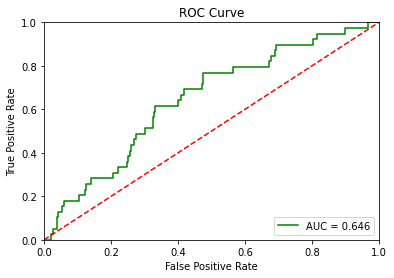

ROC AUC score: 0.6462


In [ ]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

evaluation_class(lr, X_test, y_test)

In [ ]:
prediction = lr.predict(X_test)
# preds = lr.predict(X_test)[:,1]
f1_score(y_test, prediction, average='binary')

0.0

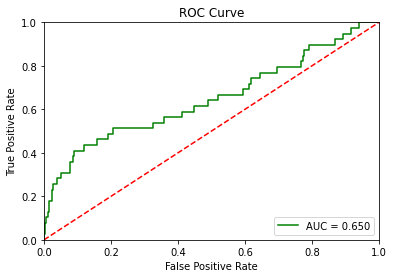

ROC AUC score: 0.6497


In [ ]:
#Constructing sentences
df_train['sentence'] = df_train.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df_train['mol2vec'] = [DfVec(x) for x in sentences2vec(df_train['sentence'], model, unseen='UNK')]
X_mol = np.array([x.vec for x in df_train['mol2vec']])
X_mol = pd.DataFrame(X_mol)

#Concatenating matrices of features
new_df_train = pd.concat((X, X_mol), axis=1)

X_train, X_test, y_train, y_test = train_test_split(new_df_train, y, test_size=.20, random_state=1)

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)


evaluation_class(lr, X_test, y_test)

In [ ]:
prediction = lr.predict(X_test)
# preds = lr.predict(X_test)[:,1]
f1_score(y_test, prediction, average='binary')

0.048780487804878044

In [ ]:
len(prediction)

1112

In [ ]:
values, counts = np.unique(prediction, return_counts=True)
values, counts

(array([0, 1]), array([1110,    2]))

In [ ]:
new_df_train

,tpsa,mol_w,num_valence_electrons,num_heteroatoms,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,51.04,190.110613,74,3,3.503211,0.191283,-0.894365,-1.829726,-9.439670,-3.740701,-5.049523,-5.310797,-4.221855,-6.348372,9.080344,-4.200541,1.413185,-5.424903,-6.724019,-1.949870,-0.612271,5.247131,1.493118,-0.800744,-4.184386,5.155531,-6.028338,6.017029,0.840196,-2.486977,-4.618838,-3.983997,2.531515,-1.163534,2.411124,8.607196,11.512511,-0.197279,-6.752950,-8.213758,...,-3.571376,-2.003661,5.325303,2.085521,0.246660,-6.378712,-0.549684,9.338679,-2.323438,6.494914,-0.675337,-8.465261,4.567844,0.090361,-3.984159,-0.952794,1.808056,3.910547,-0.821869,-8.388542,4.090080,6.280443,3.739389,-7.132612,-12.607961,7.091974,-1.062074,16.533813,0.342147,-3.141448,7.778502,3.325350,-2.497951,-9.295956,6.807944,-11.995694,-0.293787,9.527276,-8.379276,-0.718355
1,23.47,255.138992,96,3,2.610969,0.955088,-0.589977,-4.564235,-6.161839,-3.914849,-7.070612,-6.927485,-1.897713,-7.461711,12.348699,-4.571369,2.677431,-2.357007,-8.289023,-0.663212,-1.718889,5.263100,-4.074077,-6.229446,-6.502510,8.541989,-6.711815,3.316315,1.909219,1.016620,-3.373526,-6.369876,5.140145,0.730749,-4.709786,9.062553,11.981273,-0.620485,-5.481386,-6.321268,...,-3.222597,-2.560629,2.119555,5.923308,-3.946400,-6.661150,-0.602134,9.656569,-0.909792,5.363495,-1.319348,-4.034933,6.361207,-2.889800,-6.885597,-1.934168,-1.071298,-0.030595,0.166894,-6.967035,8.858186,5.513696,1.575339,-4.676562,-17.226513,11.293529,1.815377,16.219543,-2.604202,2.172944,11.328676,4.385571,-2.310262,-11.285089,7.403187,-12.987218,1.400662,9.278287,-8.317193,-1.998669
2,115.73,413.115775,150,10,1.145656,-0.470003,-4.943432,-1.837994,-10.401628,-4.078469,-9.309071,-12.443114,-4.129124,-15.155101,26.021940,-7.436653,1.189746,-7.058111,-12.968531,-5.163125,-7.649341,5.077539,-7.591770,-10.882182,-7.258201,10.934387,-14.389219,8.145875,1.711502,-1.679791,-4.916056,-6.417845,4.688525,2.327188,-3.141646,10.519517,21.770124,1.519795,-9.325136,-9.941429,...,-1.190689,-3.564704,4.625165,9.225554,-2.148237,-8.796180,-2.137119,21.121416,1.119152,17.048122,-5.057043,-9.215994,4.793064,-1.540905,-16.177752,-5.747722,1.744928,4.711153,1.743878,-15.990217,21.092360,8.613656,10.111943,-7.792122,-27.101099,16.640127,3.162718,30.339830,-5.982286,-0.503061,20.554535,1.901612,-4.389673,-15.291151,8.888416,-27.759865,6.034678,16.811232,-11.277781,-4.700245
3,86.47,443.164520,166,7,0.017530,3.324033,-5.718292,-1.050329,-12.806903,-8.483325,-12.367031,-13.724017,-9.435596,-17.614182,25.800829,-9.981343,5.074440,-8.205661,-12.806100,-5.420921,-0.409769,10.014926,-5.416377,-10.596518,-10.616245,9.447641,-17.506102,12.184483,-0.388865,-7.319726,-7.340317,-3.249032,1.013324,0.735979,0.300068,19.679682,23.613565,6.504250,-10.239435,-19.760962,...,-7.301657,-3.293212,11.992171,1.656294,6.655734,-11.565381,-6.655788,25.377403,-3.407304,24.415298,-1.889760,-16.096930,9.064987,0.042091,-15.751093,-6.682958,2.255668,7.505947,0.851673,-18.842171,16.879780,13.109829,8.594419,-10.502357,-29.697367,16.709564,4.226615,38.625935,-1.279437,-0.568445,18.297476,8.515008,-5.008985,-20.449205,13.682621,-32.041389,-0.463177,24.465450,-11.208647,-4.094455
4,40.71,331.148476,124,4,0.931080,1.338436,-7.159491,-0.203787,-13.075018,-4.092291,-9.307302,-7.556016,-6.973511,-14.225759,19.894566,-7.660346,0.934590,-8.624001,-8.521849,-2.184092,-2.656436,8.526798,-2.205572,-6.712382,-7.709054,7.390457,-13.786088,8.245339,-2.048315,-5.893801,-5.975421,-6.532150,1.322444,0.195431,-0.881044,12.589835,19.054785,4.197277,-9.217723,-13.310964,...,-3.989868,-2.109120,8.250201,1.486918,8.678454,-8.870413,-4.213999,19.154366,-1.347462,15.613173,1.716944,-13.081266,5.595106,1.349640,-9.781878,-6.868693,4.310222,6.607499,-1.612825,-15.711403,15.161274,9.494570,7.228168,-7.704036,-22.048260,15.

In [ ]:
new_df_train.columns

Index([                 'tpsa',                 'mol_w',
       'num_valence_electrons',       'num_heteroatoms',
                             0,                       1,
                             2,                       3,
                             4,                       5,
       ...
                            90,                      91,
                            92,                      93,
                            94,                      95,
                            96,                      97,
                            98,                      99],
      dtype='object', length=104)


Saving a new processed dataset for models

In [ ]:
# new_df_train.to_csv('new_train_dataset.csv', index=False)

In [ ]:
# data = pd.read_csv('/content/new_train_dataset.csv')
# data.head()

## test_csv

In [ ]:
df_test = pd.read_csv(test_dataset_path, usecols=['Smiles'])
df_test.head()

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...


In [ ]:
df_test.shape

(1614, 1)

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1614 entries, 0 to 1613
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Smiles  1614 non-null   object
dtypes: object(1)
memory usage: 12.7+ KB


In [ ]:
# Method transforms smiles strings to mol rdkit object
df_test['mol'] = df_test['Smiles'].apply(lambda x: Chem.MolFromSmiles(x)) 
print(type(df_test['mol'][0]))


<class 'rdkit.Chem.rdchem.Mol'>


In [ ]:
df_test

,Smiles,mol
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,"<img data-content=""rdkit/molecule"" src=""data:i..."
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i..."
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,"<img data-content=""rdkit/molecule"" src=""data:i..."
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i..."
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,"<img data-content=""rdkit/molecule"" src=""data:i..."
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,"<img data-content=""rdkit/molecule"" src=""data:i..."
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,"<img data-content=""rdkit/molecule"" src=""data:i..."
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,"<img data-content=""rdkit/molecule"" src=""data:i..."
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,"<img data-content=""rdkit/molecule"" src=""data:i..."


In [ ]:
# Loading pre-trained model via word2vec
from gensim.models import word2vec
model = word2vec.Word2Vec.load('/content/drive/MyDrive/Hackathon_Innopolis/model_300dim.pkl')


In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec

In [ ]:
#Extract descriptors
df_test['tpsa'] = df_test['mol'].apply(lambda x: Descriptors.TPSA(x))
df_test['mol_w'] = df_test['mol'].apply(lambda x: Descriptors.ExactMolWt(x))
df_test['num_valence_electrons'] = df_test['mol'].apply(lambda x: Descriptors.NumValenceElectrons(x))
df_test['num_heteroatoms'] = df_test['mol'].apply(lambda x: Descriptors.NumHeteroatoms(x))

In [ ]:
df_test

,Smiles,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,"<img data-content=""rdkit/molecule"" src=""data:i...",110.53,528.259737,202,11
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",22.00,269.060742,94,3
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,"<img data-content=""rdkit/molecule"" src=""data:i...",148.07,257.101171,100,8
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",110.60,261.051634,94,8
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,"<img data-content=""rdkit/molecule"" src=""data:i...",132.29,467.170588,174,10
...,...,...,...,...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,"<img data-content=""rdkit/molecule"" src=""data:i...",118.36,389.027076,130,10
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,"<img data-content=""rdkit/molecule"" src=""data:i...",100.19,348.125611,128,8
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,"<img data-content=""rdkit/molecule"" src=""data:i...",100.90,432.251189,172,6
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,"<img data-content=""rdkit/molecule"" src=""data:i...",70.51,322.142976,122,6


In [ ]:
df_test.columns

Index(['Smiles', 'mol', 'tpsa', 'mol_w', 'num_valence_electrons',
       'num_heteroatoms'],
      dtype='object')

In [ ]:
df_test

,Smiles,mol,tpsa,mol_w,num_valence_electrons,num_heteroatoms
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,"<img data-content=""rdkit/molecule"" src=""data:i...",110.53,528.259737,202,11
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,"<img data-content=""rdkit/molecule"" src=""data:i...",22.00,269.060742,94,3
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,"<img data-content=""rdkit/molecule"" src=""data:i...",148.07,257.101171,100,8
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,"<img data-content=""rdkit/molecule"" src=""data:i...",110.60,261.051634,94,8
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,"<img data-content=""rdkit/molecule"" src=""data:i...",132.29,467.170588,174,10
...,...,...,...,...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,"<img data-content=""rdkit/molecule"" src=""data:i...",118.36,389.027076,130,10
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,"<img data-content=""rdkit/molecule"" src=""data:i...",100.19,348.125611,128,8
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,"<img data-content=""rdkit/molecule"" src=""data:i...",100.90,432.251189,172,6
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,"<img data-content=""rdkit/molecule"" src=""data:i...",70.51,322.142976,122,6


In [ ]:
df_test.columns

Index(['Smiles', 'mol', 'tpsa', 'mol_w', 'num_valence_electrons',
       'num_heteroatoms'],
      dtype='object')

In [ ]:
X = df_test.drop(columns=['Smiles', 'mol'])

In [ ]:
#Constructing sentences
df_test['sentence'] = df_test.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)

#Extracting embeddings to a numpy.array
#Note that we always should mark unseen='UNK' in sentence2vec() so that model is taught how to handle unknown substructures
df_test['mol2vec'] = [DfVec(x) for x in sentences2vec(df_test['sentence'], model, unseen='UNK')]
X_mol = np.array([x.vec for x in df_test['mol2vec']])
X_mol = pd.DataFrame(X_mol)

#Concatenating matrices of features
new_df_test = pd.concat((X, X_mol), axis=1)

# X_train, X_test, y_train, y_test = train_test_split(new_df_train, y, test_size=.20, random_state=1)

# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

# lr = LogisticRegression()
# lr.fit(X_train, y_train)


# evaluation_class(lr, X_test, y_test)


This new test dataset was also saved as a csv file to feed into the model

In [ ]:
new_df_test

,tpsa,mol_w,num_valence_electrons,num_heteroatoms,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,110.53,528.259737,202,11,0.328041,-0.345891,-4.440735,-5.682992,-12.526095,-7.460945,-12.837885,-16.775339,-6.430557,-21.180212,32.545151,-14.768604,-4.684625,-4.722942,-15.620452,-7.863780,-7.477456,7.605902,-13.256824,-15.232199,-9.945791,12.932187,-16.990887,9.074331,3.752350,1.958582,-7.066084,-12.861675,10.639625,3.068378,-8.559541,15.126618,27.590384,1.117501,-10.844464,-16.688477,...,-6.289807,-5.606942,4.296750,9.297746,-4.732166,-12.882927,-2.355303,24.415714,2.529127,15.548360,-1.812549,-13.766222,11.965122,-3.254001,-14.490520,-7.517360,0.689302,4.406613,-3.041600,-22.719421,23.237129,14.339554,7.316476,-12.124749,-40.402523,28.564104,4.019253,38.274021,-8.769492,5.818077,27.001537,8.626027,-7.396129,-16.361780,13.981564,-35.691597,8.213591,20.511824,-16.299116,-1.542124
1,22.00,269.060742,94,3,-0.411078,2.976180,-4.886455,-1.208357,-6.990226,-5.065812,-5.487848,-5.835768,-3.986475,-10.372082,13.965631,-6.208488,2.837485,-4.426460,-6.752036,0.068685,-0.882996,6.134610,-4.234308,-5.131888,-9.022200,5.774152,-9.233289,5.981154,0.871859,-4.611077,0.061262,-3.115784,-2.438212,0.970966,-2.440579,12.585265,13.878915,5.839830,-7.841743,-10.329554,...,-3.580560,0.789138,9.346415,3.482605,2.510324,-6.774872,-0.435925,17.111942,-1.221593,11.166205,-0.285245,-7.911388,5.749542,0.685768,-10.179881,-3.286320,0.761277,7.010932,1.207933,-12.054438,11.118354,7.681531,3.882687,-8.372083,-15.794994,9.411275,2.435818,20.014124,0.774417,1.010595,11.924596,4.446090,-3.736063,-11.056059,6.661574,-17.842903,-1.598865,14.235581,-6.780980,-4.118220
2,148.07,257.101171,100,8,1.398110,-1.095449,-6.819747,-2.848684,-11.501495,-6.165834,-8.528183,-3.565618,-0.590316,-8.587799,10.427493,-3.537028,2.191248,-7.372274,-7.576789,-2.911187,-0.213280,2.821966,4.179483,-5.501786,-5.535944,12.163441,-7.231833,7.785953,-1.313398,-4.393950,-0.602306,-5.857956,-1.748660,-2.678023,7.044590,9.208630,10.349787,-0.854619,-8.022717,-10.346584,...,-3.735419,1.597370,4.847353,2.328058,-5.948441,-5.926282,-3.280214,12.192876,-2.988242,5.788051,-5.712585,-7.640658,9.099349,-6.135124,-3.953731,-2.679121,3.524614,1.509492,0.682289,-3.005456,3.647984,4.136155,-0.974471,-4.339217,-15.894867,7.971863,3.692828,19.822618,0.251753,-9.149258,11.047467,0.357122,-0.765058,-13.868602,10.579711,-18.839451,1.441431,12.439246,-16.273199,-1.212704
3,110.60,261.051634,94,8,-1.484684,2.882364,-2.297640,-3.874132,-4.682063,-3.045850,-0.653581,-7.555736,5.740156,-6.879496,13.040290,-9.922798,-0.835427,-5.462558,-8.374475,0.206205,-6.785543,-0.816823,-1.521242,-3.692111,-7.790720,7.089456,-7.745568,-0.091685,-1.583371,3.840924,-1.516020,-7.332675,1.819310,-4.276120,-0.062181,3.382858,9.236603,4.130234,-8.222047,-7.182144,...,-4.072776,-1.926684,-0.845994,0.336619,-10.241670,-7.350274,4.602876,10.507168,5.547297,4.812106,0.835868,-5.881299,12.548648,-2.283665,-6.514899,-2.311008,5.313168,5.867330,-2.872912,-6.810446,2.987467,5.359791,-1.237576,-3.158195,-18.481003,13.120938,1.120301,18.367579,-6.642848,0.520489,8.724115,4.892698,-6.694263,-12.324293,13.397848,-14.140556,1.728293,3.951265,-13.480573,3.640517
4,132.29,467.170588,174,10,-2.450051,2.257695,-5.700334,-4.145693,-11.492740,-2.634877,-8.675226,-14.204074,-6.761897,-22.005455,30.786238,-16.840698,-4.819994,-6.612446,-11.062019,-7.211842,-6.604141,10.001628,-10.759573,-9.031163,-8.718495,7.740344,-12.956320,11.110654,2.259195,-1.016021,-5.960052,-11.462557,8.309057,-0.433505,-4.746221,13.189224,28.867172,3.049298,-9.212698,-18.261427,...,-3.841791,-1.900962,7.653656,4.660765,2.085400,-10.484140,-2.404604,20.068281,1.330302,17.288219,0.193566,-12.627249,12.641295,-2.062991,-15.898194,-7.991343,2.638541,8.079391,-0.624180,-20.879433,20.871975,9.931360,10.464426,-

In [ ]:
test_prediction = lr.predict(new_df_test)
# preds = lr.predict(X_test)[:,1]
# f1_score(y_test, prediction, average='binary')
test_prediction


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/test.csv', usecols=['Smiles'])
df_sub

,Smiles
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...
...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1


In [ ]:
df_sub['Active_pred'] = test_prediction
df_sub

,Smiles,Active_pred
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,1
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,1
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,1
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,1
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,1
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,1
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,1
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,1


In [ ]:
df_sub['Active_pred'].value_counts()

1    1614
Name: Active_pred, dtype: int64

In [ ]:
df_sub.to_csv('submission.csv', index=False)

In [ ]:
df = pd.read_csv('/content/submission.csv')
df

,Smiles,Active_pred
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,1
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,1
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,1
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,1
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,1
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,1
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,1
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,1


In [ ]:
# with StandardScaler
X_test = StandardScaler().fit_transform(new_df_test)
test_prediction = lr.predict(X_test)
test_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
values, counts = np.unique(test_prediction, return_counts=True)
values, counts

(array([0, 1]), array([1612,    2]))

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/test.csv', usecols=['Smiles'])
df_sub['Active_pred'] = test_prediction
df_sub['Active_pred'].value_counts()

0    1612
1       2
Name: Active_pred, dtype: int64

In [ ]:
df_sub.to_csv('submission.csv', index=False)
df = pd.read_csv('/content/submission.csv')
df['Active_pred'].value_counts()

0    1612
1       2
Name: Active_pred, dtype: int64

# XGBoost

There was an attempt to use XGBoost

In [ ]:
import gc
gc.collect()

486

In [ ]:
import xgboost as xgb


New train and test datasets were created to train the models:
* new_train_dataset.csv
* new_test_dataset.csv

In [ ]:
df_train = pd.read_csv(train_dataset_path, usecols=['Smiles', 'Active'])
df_test = pd.read_csv(test_dataset_path, usecols=['Smiles'])
new_train_dataset = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/new_train_dataset.csv')
new_test_dataset = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/new_test_dataset.csv')

In [ ]:
df_train["Active"] = df_train["Active"].astype("int64")
df_train

,Smiles,Active
0,COc1ccc2[nH]cc(CCN)c2c1,0
1,CCCN1CCC[C@H](c2cccc(O)c2)C1.Cl,0
2,O=C(NO)c1cnc(N2CCN(S(=O)(=O)c3ccc4ccccc4c3)CC2...,0
3,Nc1cccc(CNC(=O)c2ccc(Oc3ccc(OCc4cccc(F)c4)cc3)...,0
4,Fc1ccccc1CNCc1ccc(-c2ccnc3[nH]ccc23)cc1,0
...,...,...
5552,O=C(Oc1ccc([N+](=O)[O-])cc1)N1CCC(C(O)(c2ccc3c...,0
5553,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Br)c1,0
5554,Oc1cccc2cccnc12,0
5555,OC(c1ccc(-c2ccc(CN3CCN(Cc4ccncc4)CC3)cc2)c(F)c...,0


In [ ]:
y = df_train['Active'].values
X_train, X_test, y_train, y_test = train_test_split(new_train_dataset, y,
                                                    test_size=.20, shuffle=True, # .20, 0.30, 0.1
                                                    stratify=y, random_state=123) # 123, 42

In [ ]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [ ]:
print("Train set labels distibution: {}".format(np.bincount(y_train)))
print("Test set labels distibution:  {}".format(np.bincount(y_test)))

Train set labels distibution: [4280  165]
Test set labels distibution:  [1071   41]


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
# params = {"objective": "binary:logistic", "max_depth": 1, "silent": 1, "eta": 1}

# num_rounds = 15

# params = {"objective": "binary:logistic", "max_depth": 4, "silent": 1, "eta": 0.3}

# num_rounds = 100

# params = {"objective": "binary:logistic", "max_depth": 5, "silent": 1, "eta": 1} # f1=0.2333

# num_rounds = 100 

params = {"objective": "binary:logistic", "max_depth": 5, "silent": 1, "eta": 1,
          'eval_metric':'auc', 'seed': 1234, 'min_child_weight':1} # 5, 10, 6

num_rounds = 100 # 50, 100, 500, 20

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)
# y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")
y_test_preds  = (xgb_model.predict(dtest) > 0.5).astype('int')
y_test_preds

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
values, counts = np.unique(y_test, return_counts=True)
values, counts

(array([0, 1]), array([1071,   41]))

In [ ]:
values, counts = np.unique(y_test_preds, return_counts=True)
values, counts

(array([0, 1]), array([1093,   19]))

In [ ]:
f1_score(y_test, y_test_preds, average='binary')

0.23333333333333336

In [ ]:
pd.crosstab(
    pd.Series(y_test, name="Actual"),
    pd.Series(y_test_preds, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0,1059,12,1071
1,34,7,41
All,1093,19,1112


In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision: {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall: {0:.2f}".format(recall_score(y_test, y_test_preds)))

Accuracy: 0.96
Precision: 0.37
Recall: 0.17


## Setting the weights manually

In [ ]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = -5 # 1
weights[y_train == 1] = 1 # 5

dtrain = xgb.DMatrix(X_train, label=y_train, weight=weights)  # weights added
dtest = xgb.DMatrix(X_test)

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")

In [ ]:
values, counts = np.unique(y_test_preds, return_counts=True)
values, counts

(array([1]), array([1112]))

In [ ]:
f1_score(y_test, y_test_preds, average='binary')

0.07111882046834345

In [ ]:
pd.crosstab(
    pd.Series(y_test, name="Actual"),
    pd.Series(y_test_preds, name="Predicted"),
    margins=True,
)

Predicted,1,All
Actual,,
0,1071,1071
1,41,41
All,1112,1112


In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision: {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall: {0:.2f}".format(recall_score(y_test, y_test_preds)))

Accuracy: 0.04
Precision: 0.04
Recall: 1.00


## Parameter scale_pos_weight

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [ ]:
train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)
# params["scale_pos_weight"] = ratio

params["scale_pos_weight"] = 1

In [ ]:
values, counts = np.unique(train_labels, return_counts=True)
values, counts

(array([0., 1.], dtype=float32), array([4280,  165]))

In [ ]:
xgb_model = xgb.train(params, dtrain, num_rounds)
y_test_preds = (xgb_model.predict(dtest) > 0.5).astype("int")

pd.crosstab(
    pd.Series(y_test, name="Actual"),
    pd.Series(y_test_preds, name="Predicted"),
    margins=True,
)

Predicted,0,1,All
Actual,,,
0,1059,12,1071
1,34,7,41
All,1093,19,1112


In [ ]:
f1_score(y_test, y_test_preds, average='binary')

0.23333333333333336

In [ ]:
print("Accuracy: {0:.2f}".format(accuracy_score(y_test, y_test_preds)))
print("Precision: {0:.2f}".format(precision_score(y_test, y_test_preds)))
print("Recall: {0:.2f}".format(recall_score(y_test, y_test_preds)))

Accuracy: 0.96
Precision: 0.37
Recall: 0.17


In [ ]:
values, counts = np.unique(y_test_preds, return_counts=True)
values, counts

(array([0, 1]), array([1093,   19]))

## Submission.csv

In [ ]:
# to_csv Submission.csv
X_test_dataset = StandardScaler().fit_transform(new_test_dataset)
X_dtest = xgb.DMatrix(X_test_dataset)
# test_prediction = (xgb_model.predict(X_test_dataset) > 0.5).astype("int")
test_prediction = (xgb_model.predict(X_dtest) > 0.5).astype("int")
print(test_prediction)

values, counts = np.unique(test_prediction, return_counts=True)
print(values, counts)

# df_sub = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/test.csv', usecols=['Smiles'])
df_test['Active_pred'] = test_prediction
print(df_test['Active_pred'].value_counts())

df_test.to_csv('submission.csv', index=False)
df = pd.read_csv('/content/submission.csv')
print(df['Active_pred'].value_counts())

[0 0 1 ... 0 0 0]
[0 1] [1607    7]
0    1607
1       7
Name: Active_pred, dtype: int64
0    1607
1       7
Name: Active_pred, dtype: int64


In [ ]:
df_submission = pd.read_csv('/content/drive/MyDrive/Hackathon_Innopolis/submission(4).csv')
df_submission

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,0
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,0
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,1
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,0
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,0
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,0
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,0
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,0
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,0


In [ ]:
# df_submission_pred=df_submission['Active']
# df_submission_pred

0       0
1       0
2       1
3       0
4       0
       ..
1609    0
1610    0
1611    0
1612    0
1613    0
Name: Active_pred, Length: 1614, dtype: int64

In [ ]:
df_submission.to_csv('submission.csv', index=False)

In [ ]:
df_submission_pred.to_csv('submission_2.csv', index=False, header=False)

# target.pdb

In [ ]:
!pip install biopandas

     |████████████████████████████████| 264 kB 5.2 MB/s 


In [ ]:
# rdkit
# if you use colab try this:
# !python -m pip install rdkit-pypi

In [ ]:
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()
ppdb.read_pdb('/content/drive/MyDrive/Hackathon_Innopolis/target.pdb')
# ppdb.df.keys()

In [ ]:
ppdb.df.keys()

dict_keys(['ATOM', 'HETATM', 'ANISOU', 'OTHERS'])

In [ ]:
ppdb.df['HETATM'].head(2)

,record_name,atom_number,blank_1,atom_name,alt_loc,residue_name,blank_2,chain_id,residue_number,insertion,blank_3,x_coord,y_coord,z_coord,occupancy,b_factor,blank_4,segment_id,element_symbol,charge,line_idx
0,HETATM,3986,,O,,HOH,,A,201,,,36.693,21.765,14.383,0.58,11.17,,,O,NaN,6391
1,HETATM,3987,,O,,HOH,,A,202,,,23.676,22.427,25.958,1.00,34.56,,,O,NaN,6393


In [ ]:
ppdb.df

{'ANISOU':      record_name  atom_number blank_1  ... element_symbol charge line_idx
 0         ANISOU            1          ...              N    NaN      413
 1         ANISOU            2          ...              N    NaN      415
 2         ANISOU            3          ...              C    NaN      417
 3         ANISOU            4          ...              C    NaN      419
 4         ANISOU            5          ...              C    NaN      421
 ...          ...          ...     ...  ...            ...    ...      ...
 2305      ANISOU         4297          ...              O    NaN     7014
 2306      ANISOU         4298          ...              O    NaN     7016
 2307      ANISOU         4299          ...              O    NaN     7018
 2308      ANISOU         4300          ...              O    NaN     7020
 2309      ANISOU         4301          ...              O    NaN     7022
 
 [2310 rows x 21 columns],
 'ATOM':      record_name  atom_number blank_1  ... element_s